# Popeye demo

# Goals 

1. Run through the popeye tutorial materials (but explore in more depth where required)
2. Make some useful functions. 
3. Start to think about how I can start to plug in my own data. 

In [2]:
import ctypes, multiprocessing
import numpy as np
import sharedmem
import popeye.og_hrf as og
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus, simulate_bar_stimulus

# seed random number generator so we get the same answers ...
np.random.seed(2764932)

The first thing we are asked to do define is the 'sweeps'. These define the angle at which the bar traverses the screen (in degrees). -1 indicates a blank period (i.e. no bar pass). We pass all this information into a numpy array.   

In [3]:
sweeps = np.array([-1,0,90,180,270,-1])

The next thing that we do is define the bar itself. I give comments on the input below, based on my reading of the API (http://kdesimone.github.io/popeye/docs/_build/html/reference/popeye.simulation.html?highlight=simulate_bar_stimulus#popeye.simulation.simulate_bar_stimulus)

In [4]:
# The number of screen pixels in the horizontal dimension
pix_across=100

# The number of screen pixels in the vertical dimension
pix_down=100

# The viewing distance in cm
viewdist_cm=40

# The distance across the screen in cm
screenwidth_cm=20

# Number of steps in a bar pass
num_steps=30

# Number of steps in a 'null' bar pass
num_steps_null=30

# Distance from fixation that the bar sweep finishes and ends (degrees). 
ecc=10

bar = simulate_bar_stimulus(pix_across, pix_down, viewdist_cm, screenwidth_cm, sweeps, num_steps, num_steps_null, ecc)

I'm not quite sure how it makes sense to define the start and end eccentricity in degrees, when everything else is currently defined in cm/pixels.

Also, as far as I can tell, the bar width is not defined anywhere?

In [5]:
bar.shape

(100, 100, 180)

The first two dimensions are the screen size. The third is time. Im going to plot the bar at various time points so that I can test my intuitions about it.  

Since the first period is a blank period and this lasts for 30 time points, we wouldnt expect to see anything until after this point. 

In [6]:
import matplotlib.pyplot as plt

plt.imshow(bar[:,:,30])

Now I want to define a function for visualising the bar across sweeps of the screen.

In [7]:
def plotbarsweep(bar,sweepnum,steps,nsamps):
    startpoint=(sweepnum*steps)
    plt.subplots(figsize=((nsamps*10), 10))
    samps=np.floor(np.linspace(startpoint,(startpoint+steps)-1,nsamps))
    x=(np.floor(samps))
    x2=x.astype(int)
    for i in range(len(x2)):
        plt.subplot(1,nsamps,i+1)
        plt.imshow(bar[:,:,(x2[i])])

Plot first bar sweep (null period)

In [8]:
plotbarsweep(bar,0,30,10)

Plot the second bar sweep (0 degrees)

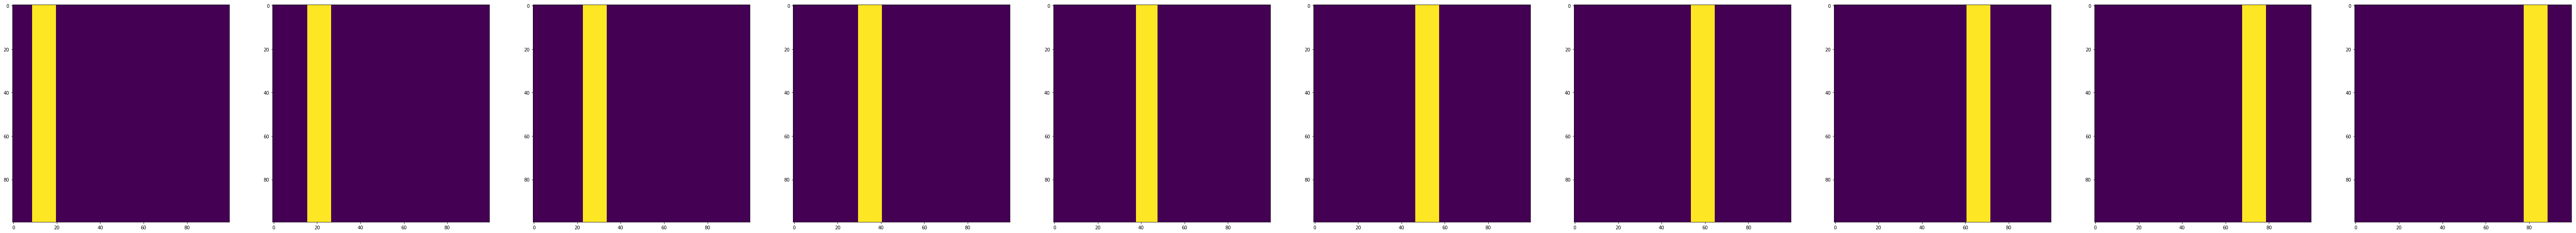

In [9]:
plotbarsweep(bar,1,30,10)

Plot the third bar sweep (90 degrees)

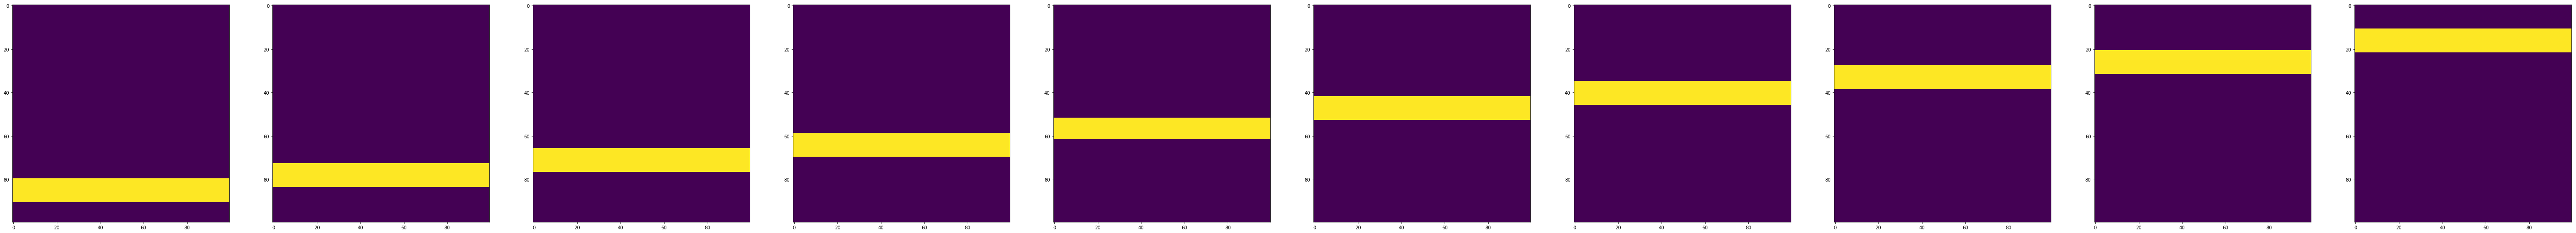

In [10]:
plotbarsweep(bar,2,30,10)

180 degrees

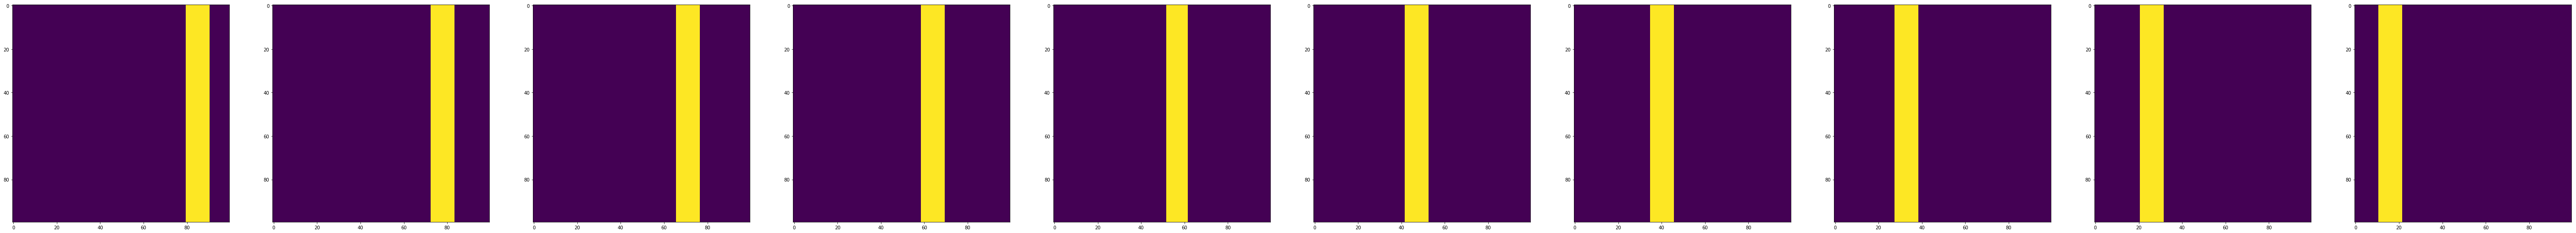

In [11]:
plotbarsweep(bar,3,30,10)

270 degrees

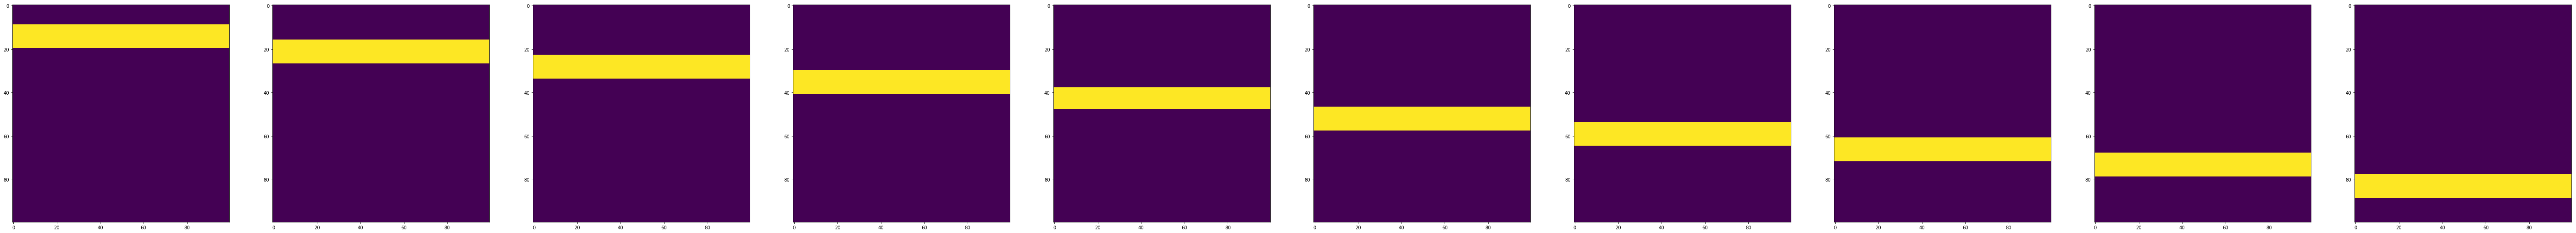

In [12]:
plotbarsweep(bar,4,30,10)

Null period

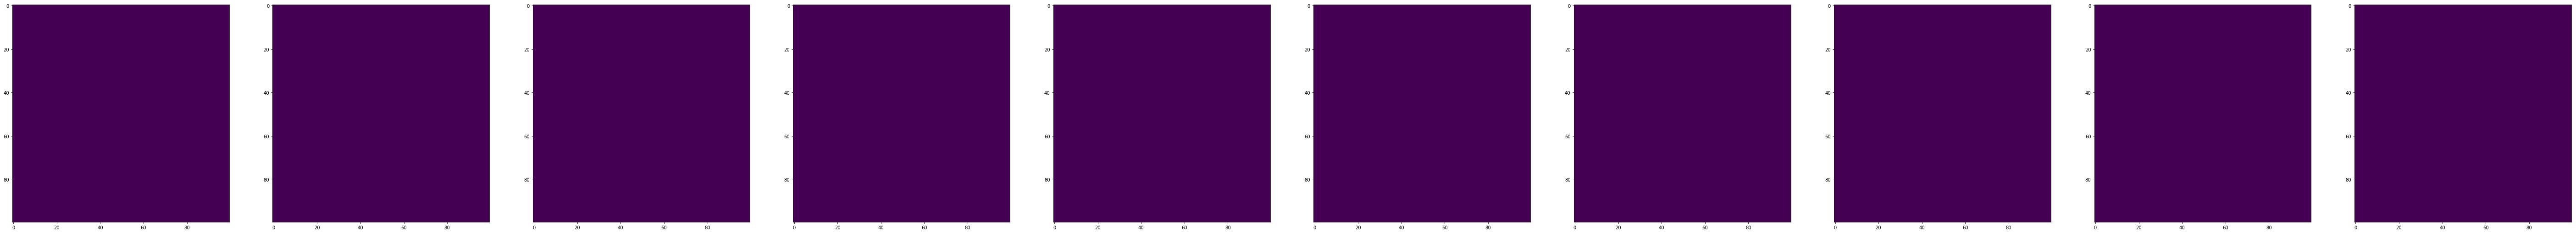

In [13]:
plotbarsweep(bar,5,30,10)

Next, we are required to make our bar stimulus into a 'VisualStimulus' (why?)

http://kdesimone.github.io/popeye/docs/_build/html/reference/popeye.visual_stimulus.html#popeye.visual_stimulus.VisualStimulus

In [14]:
# The length of a TR
tr_length=1

# The downsampling rate. The stim_arr is downsampled so as to speed up the fitting procedure. The final model estimates will be derived using the original stimulus.
scale_factor=.5 

stimulus = VisualStimulus(bar, viewdist_cm, screenwidth_cm, scale_factor, tr_length, ctypes.c_int16)

Now let's initialise our model. We use a simple gaussian model, as in Dumoulin SO, Wandell BA. (2008). The two arguments are our i) our stimulus and ii) a model hrf. 

In [15]:
model = og.GaussianModel(stimulus, utils.double_gamma_hrf)

The stimulus itself we have looked at. The hrf is a function that takes in two arguments.

http://kdesimone.github.io/popeye/docs/_build/html/reference/popeye.utilities.html#popeye.utilities.double_gamma_hrf

In [16]:
# The delay of the HRF peak and undershoot (Units are not specified).
hrf_delay=-0.25

# The TR (seconds)
TR=1

plt.plot(utils.double_gamma_hrf(hrf_delay,TR))

This is the hrf that we convolve with our spatial model. 

So to generate predictions, let's make a model prf. 

Then, in effect, we ask the question "How would be expect a voxel with this prf, to respond to this stimulus?"

In [17]:
# X coordinate
x = -5.24

# Y coordinate
y = 2.58

# SD
sigma = 1.24

To generate the model predictions for this prf, we used the 'generate_prediction' method.

There are a couple additional parameters to add. (Note that the API doesn't explain what these are). 

In [62]:
beta = 0.55
baseline = -0.88


data = model.generate_prediction(x, y, sigma, hrf_delay, beta, baseline)

figsizex=70
figsizey=10


def plotmodelpred(model,x, y, sigma, hrf_delay, beta, baseline,figsizex,figsizey):
    data = model.generate_prediction(x, y, sigma, hrf_delay, beta, baseline)
    ylim=(np.min(data),np.max(data))
    plt.figure(figsize=(figsizex,figsizey))
    plt.plot(data)
    plt.rcParams.update({'font.size': 40})
    plt.ylim(ylim)
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.show()

def plotts(data):
    ylim=(np.min(data),np.max(data))
    plt.figure(figsize=(figsizex,figsizey))
    plt.plot(data)
    plt.rcParams.update({'font.size': 40})
    plt.ylim(ylim)
    plt.xlabel('Time')
    plt.ylabel('Response')
    plt.show()

In [63]:
plotmodelpred(model,x,y,sigma,hrf_delay,beta,baseline,figsizex,figsizey)

There are 4 peaks in the data, which correspond to the 4 times that the bar stimulates the prf

Beta would seem to correspond to a factor that defines the height of the prf peaks. Baseline would seem to correspond to a factor that defines the signal in the absence of any stimulation

Next, to make this seem like real data, we can add noise to it. Then we can aim to find the prf parameters that best explain the data

In [64]:
data += np.random.uniform(-data.max()/10,data.max()/10,len(data))

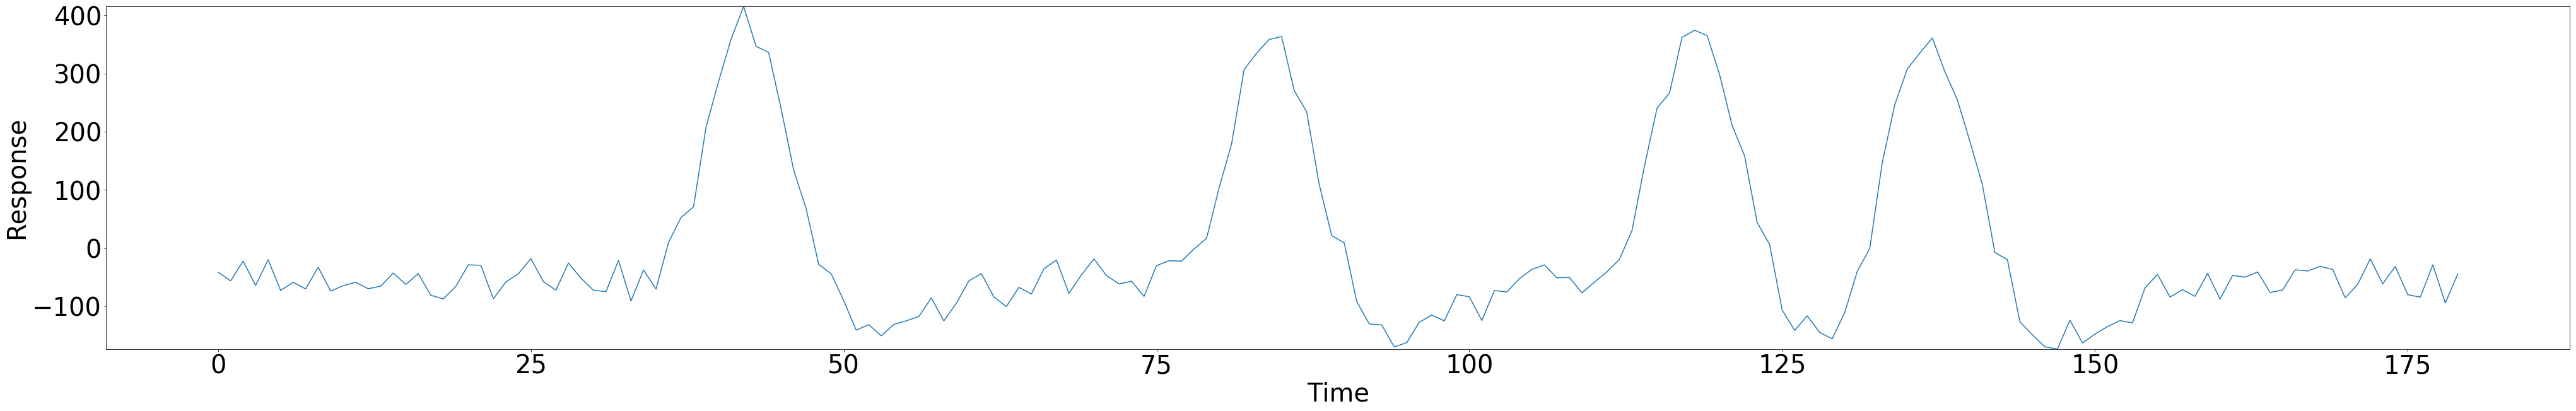

In [65]:
plotts(data)

So now we aim to fit the model. This is done via the GaussianFit method http://kdesimone.github.io/popeye/docs/_build/html/reference/popeye.og.html#popeye.og.GaussianFit

We first need to define a set of grids and bounds.

**Grids** define the minimum and maximum edge of the initial grid search (degrees, I guess?).

**Bounds** define the boundaries of the gradient descent search itself.

We define grids and bounds for each parameter.

In [66]:
# X location grid
x_grid = (-10,10)

# Y location grid
y_grid = (-10,10)

# SD location grid. Here the minimum is set to 1 pixel. 
s_grid = (1/stimulus.ppd + 0.25,5.25)

# This would seem to have to be the beta parameter?
b_grid = (0.1,1.0)

# This would seem to baseline parameter?
h_grid = (-1.0,1.0)


x_bound = (-12.0,12.0)

y_bound = (-12.0,12.0)

s_bound = (1/stimulus.ppd, 12.0)

b_bound = (1e-8,None)

u_bound = (None,None)

h_bound = (-3.0,3.0)

## package the grids and bounds
grids = (x_grid, y_grid, s_grid, h_grid)

bounds = (x_bound, y_bound, s_bound, h_bound, b_bound, u_bound,)

In addition, we include the additional parameter **Ns**, which is 'the number of samples per stimulus dimension to sample during the ballpark search'.   

In [67]:
Ns=3

The one other optional argument we pass is the voxel index. This is presumably useful for relating the data to the coordinates of the volume. I'm going to choose very verbose output (2) so I can get some idea of what is going on under the hood.

In [68]:
fit = og.GaussianFit(model, data, grids, bounds, Ns=Ns, voxel_index=(1,2,3), auto_fit=True,verbose=2)

(array([-10.        , -10.        ,   0.53072487,  -1.        ]), 3641953.5417559273)
(array([-10.        , -10.        ,   0.53072487,  -1.        ]), 3641953.5417559273)
(array([-10.        , -10.        ,   0.53072487,   0.        ]), 3659467.3380812)
(array([-10.        , -10.        ,   0.53072487,   1.        ]), 3677287.737212518)
(array([-10.        , -10.        ,   2.89036243,  -1.        ]), 3667987.02300799)
(array([-10.        , -10.        ,   2.89036243,   0.        ]), 3660330.6145497262)
(array([-10.        , -10.        ,   2.89036243,   1.        ]), 3655318.602366871)
(array([-10.  , -10.  ,   5.25,  -1.  ]), 3520158.28882916)
(array([-10.  , -10.  ,   5.25,   0.  ]), 3506043.4964106577)
(array([-10.  , -10.  ,   5.25,   1.  ]), 3510373.4691550387)
(array([-10.        ,   0.        ,   0.53072487,  -1.        ]), 3339278.455940217)
(array([-10.        ,   0.        ,   0.53072487,   0.        ]), 3267342.862445617)
(array([-10.        ,   0.        ,   0.53072487,  

(array([-6.97194667,  2.71921208,  2.46455307,  0.        ,  0.69719475,
       -1.76496681]), 735949.6952774536)
(array([-6.97194667,  2.71921208,  2.4366986 ,  0.        ,  0.69719475,
       -1.76496681]), 735960.1183663977)
(array([-6.97194667,  2.71921208,  2.49240754,  0.        ,  0.69719475,
       -1.76496681]), 736329.9460725277)
(array([-6.97194667,  2.71921208,  2.46455307,  0.        ,  0.69719475,
       -1.76496681]), 735949.6952774536)
(array([-6.97194667,  2.71921208,  2.46455307,  1.        ,  0.69719475,
       -1.76496681]), 1006723.0758320459)
(array([-6.97194667,  2.71921208,  2.46455307, -1.618034  ,  0.69719475,
       -1.76496681]), 1365171.22034528)
(array([-6.97194667,  2.71921208,  2.46455307,  0.        ,  0.69719475,
       -1.76496681]), 735949.6952774536)
(array([-6.97194667,  2.71921208,  2.46455307, -0.61803397,  0.69719475,
       -1.76496681]), 761513.5606591261)
(array([-6.97194667,  2.71921208,  2.46455307,  0.381966  ,  0.69719475,
       -1.76496

(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -0.76496681]), 108609.9964276849)
(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -3.38300081]), 108901.2425522224)
(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -1.76496681]), 108429.99642768849)
(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -2.38300078]), 108498.75030662178)
(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -1.38300081]), 108456.2580722152)
(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -1.76496681]), 108429.9964276885)
(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -1.76909641]), 108429.99949733977)
(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -1.76654418]), 108429.99687554457)
(array([-5.40108233,  2.49470666,  1.60390113, -0.2434217 ,  0.59202141,
       -1.7

(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.97398741,
       -1.7649669 ]), 1928775.9292743043)
(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.35595344,
       -1.7649669 ]), 587605.3054619371)
(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.56782043,
       -1.7649669 ]), 86273.20001596313)
(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.56806244,
       -1.7649669 ]), 86273.8541468865)
(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.56757842,
       -1.7649669 ]), 86273.8541468865)
(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.56782043,
       -1.7649669 ]), 86273.20001596313)
(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.56782043,
       -0.7649669 ]), 86453.19998342782)
(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.56782043,
       -3.3830009 ]), 86744.44619313443)
(array([-5.28922022,  2.52675131,  1.41306939, -0.27531685,  0.56782043,
       -1.764966

(array([-5.27831964,  2.52966922,  1.28892448, -0.3223219 ,  0.55207657,
       -1.76496683]), 80726.8708993223)
(array([-5.27831964,  2.52966922,  1.28892448, -0.32206195,  0.55207657,
       -1.76496683]), 80726.84050059505)
(array([-5.27831964,  2.52966922,  1.28892448, -0.32206195,  1.55207657,
       -1.76496683]), 12001959.818518614)
(array([-5.27831964,  2.52966922,  1.28892448, -0.32206195,  0.55207657,
       -1.76496683]), 80726.84050059505)
(array([-5.27831964,  2.52966922,  1.28892448, -0.32206195,  0.93404257,
       -1.76496683]), 1827429.581059816)
(array([-5.27831964,  2.52966922,  1.28892448, -0.32206195,  0.31600861,
       -1.76496683]), 735904.6799016197)
(array([-5.27831964,  2.52966922,  1.28892448, -0.32206195,  0.55075507,
       -1.76496683]), 80706.07652416488)
(array([-5.27831964,  2.52966922,  1.28892448, -0.32206195,  0.55074186,
       -1.76496683]), 80706.07860056567)
(array([-5.27831964,  2.52966922,  1.28892448, -0.32206195,  0.55076829,
       -1.76496

(array([-5.27721789,  2.52972725,  1.25415994, -0.32335335,  1.54634629,
       -1.76496677]), 12135119.9240751)
(array([-5.27721789,  2.52972725,  1.25415994, -0.32335335,  0.54634629,
       -1.76496677]), 80266.27264632063)
(array([-5.27721789,  2.52972725,  1.25415994, -0.32335335,  0.92831229,
       -1.76496677]), 1836619.028874652)
(array([-5.27721789,  2.52972725,  1.25415994, -0.32335335,  0.31027832,
       -1.76496677]), 755059.5960113534)
(array([-5.27721789,  2.52972725,  1.25415994, -0.32335335,  0.54677228,
       -1.76496677]), 80264.08324794756)
(array([-5.27721789,  2.52972725,  1.25415994, -0.32335335,  0.54676802,
       -1.76496677]), 80264.08346688843)
(array([-5.27721789,  2.52972725,  1.25415994, -0.32335335,  0.54677654,
       -1.76496677]), 80264.08346688843)
(array([-5.27721789,  2.52972725,  1.25415994, -0.32335335,  0.54677228,
       -1.76496677]), 80264.08324794756)
(array([-5.20444639,  2.55057378,  1.13001502, -0.34410262,  0.53102842,
       -1.764966

(array([-5.27724562,  2.53000693,  1.22856066, -0.32043745,  0.54411027,
       -1.76496681]), 80163.22273800545)
(array([-5.27201747,  2.53162877,  1.23549214, -0.32145711,  0.54478398,
       -1.76496684]), 80179.09876029033)
(array([-5.28047679,  2.52900458,  1.22427678, -0.31980727,  0.54369389,
       -1.76496679]), 80169.5288003501)
(array([-5.27720638,  2.5300191 ,  1.22861269, -0.32044511,  0.54411533,
       -1.76496681]), 80163.22180373927)
(array([-5.27720581,  2.53001928,  1.22861345, -0.32044522,  0.5441154 ,
       -1.76496681]), 80163.2218035488)
(array([-5.27720541,  2.5300194 ,  1.22861398, -0.3204453 ,  0.54411545,
       -1.76496681]), 80163.2218036444)
VOXEL=(001,002,003)   TIME=005   RSQ=0.98  EST=[ 2.6945  5.8523  1.2286 -0.3204  0.5441 -1.765 ]


The results of the fitting process are returned in the 'fit' variable. So now I take a look at that.

The fitted parameters are returned in **estimate**

In [69]:
fit.estimate

array([-5.27720581,  2.53001928,  1.22861345, -0.32044522,  0.5441154 ,
       -1.76496681])

These are pretty close to the parameters we created the data with. Indeed, the **rsquared** is very high.

In [70]:
fit.rsquared

0.9782593782189735

The prf itself is returned in the **receptive_field** variable. 

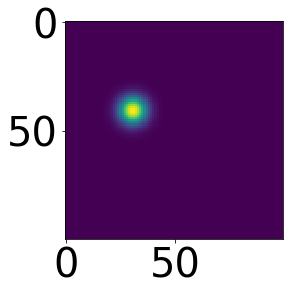

In [71]:
plt.imshow(fit.receptive_field)

It might be nice to summarise the predictions of the model alongside the data.

In [72]:
def plotbar(bar,fit,nsamps,idxmin,idxmax):
    plt.subplots(figsize=((nsamps*4), 20))
    
    if not idxmin:
        idxmin=0
        idxmax=(bar.shape[2]-1)
    samps=np.floor(np.linspace(idxmin,idxmax,nsamps))
    x=(np.floor(samps))
    x2=x.astype(int)
    for i in range(len(x2)):
        plt.subplot(1,nsamps,i+1)
        plt.imshow(fit.receptive_field) 
        plt.imshow(bar[:,:,(x2[i])], cmap='hot', alpha=0.5)
        

In [73]:
plotbar(bar,fit,20,[],[])

In [74]:
def plotprfpred(fit,bar,nsamps,idxmin,idxmax):

    import matplotlib.mlab as mlab
    import matplotlib.gridspec as gridspec
    fig = plt.figure(constrained_layout=True,figsize=((nsamps*4), 20))
    gs = gridspec.GridSpec(4,nsamps, figure=fig)
    
    if not idxmin:
        idxmin=0
        idxmax=(len(fit.data)-1)

    ax1 = fig.add_subplot(gs[1:4, :])
    ax1.plot(fit.prediction[idxmin:idxmax])
    ax1.plot(np.array(fit.data[idxmin:idxmax]))
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('signal')

    ax2 = plotbar(bar,fit,nsamps,idxmin,idxmax)
    plt.title('Stimulus')

    plt.show()

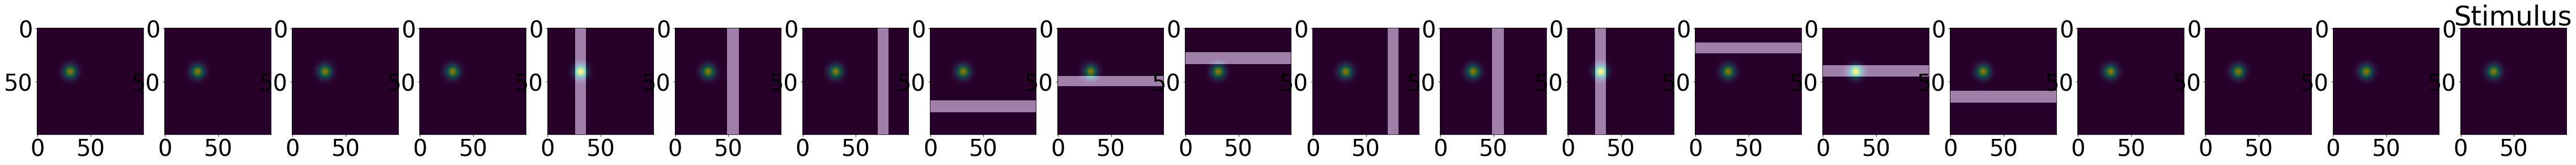

In [75]:
plotprfpred(fit,bar,20,[],[])

Note how the response increases when the stimulus overlaps with the bar.

That is reassuring. 

# Kay example data

Now, I am going to use some real data and stimuli. These are both taken from the demo for analyze prf (https://kendrickkay.net/analyzePRF/html/example1.html).  

I have donwloaded the stimuli and converted them to jpg image files. Therefore, my first goal is to convert all this into a VisualStimulus class. First, I bundle all of these images together into an (x,y,t) array.

In [76]:
stimdir='/media/nicholas/STORE/NICKDAT/KAYDATA/Misc-20200326T160801Z-001/Misc'

import os
from PIL import Image
import sklearn.preprocessing as skp
def make_bar_array(dir,ext,sizex,sizey):
    stimlist=list()
 
    for file in os.listdir(dir):
        if file.endswith(ext):
            stimlist.append(dir+"/"+file)
            stimlist.sort(key=lambda f: int(filter(str.isdigit, f)))
    
    stimarray=np.empty([sizex,sizey,len(stimlist)])
    
    i=0
    for stim in stimlist:
        
        image = Image.open(stim)
        stimmat=np.asarray(image)
        binstimmat=skp.binarize(stimmat,120)
        
        stimarray[:,:,i]=binstimmat
        i=i+1
    return stimarray

kaybar=make_bar_array(stimdir,'.jpg',100,100)

We now have a numpy array with the binary stimulus frames

In [77]:
kaybar.shape

(100, 100, 1200)

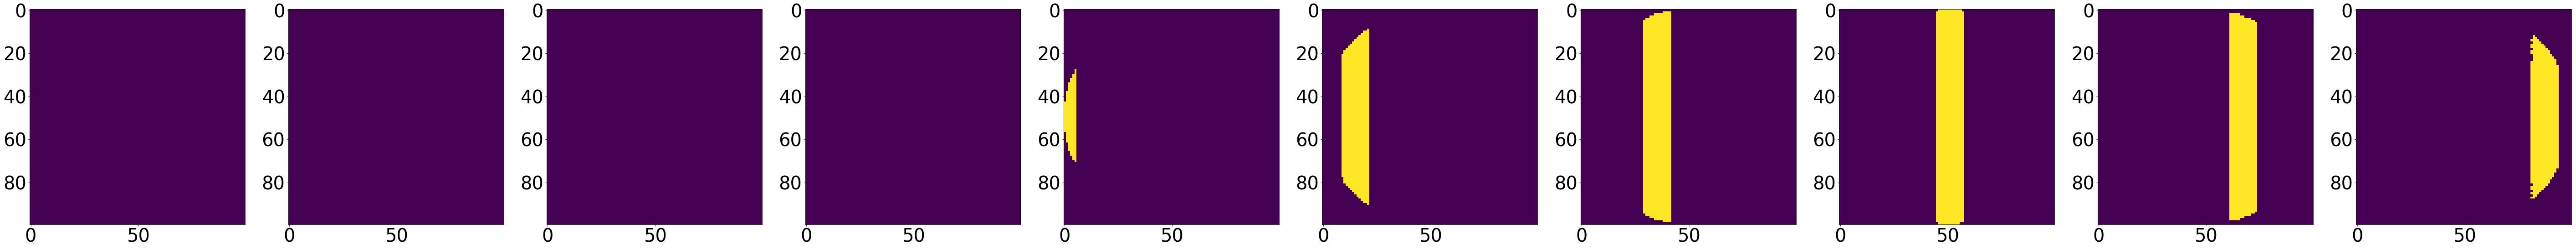

In [78]:
plotbarsweep(kaybar,0,40,10)

In [79]:
import pandas as pd
DATA=pd.read_csv(stimdir+'/DATA.csv',header=None) 

The data are the same length as the stimulus (1200). We have data from 10 voxels.

In [80]:
DATA.shape

(10, 1200)

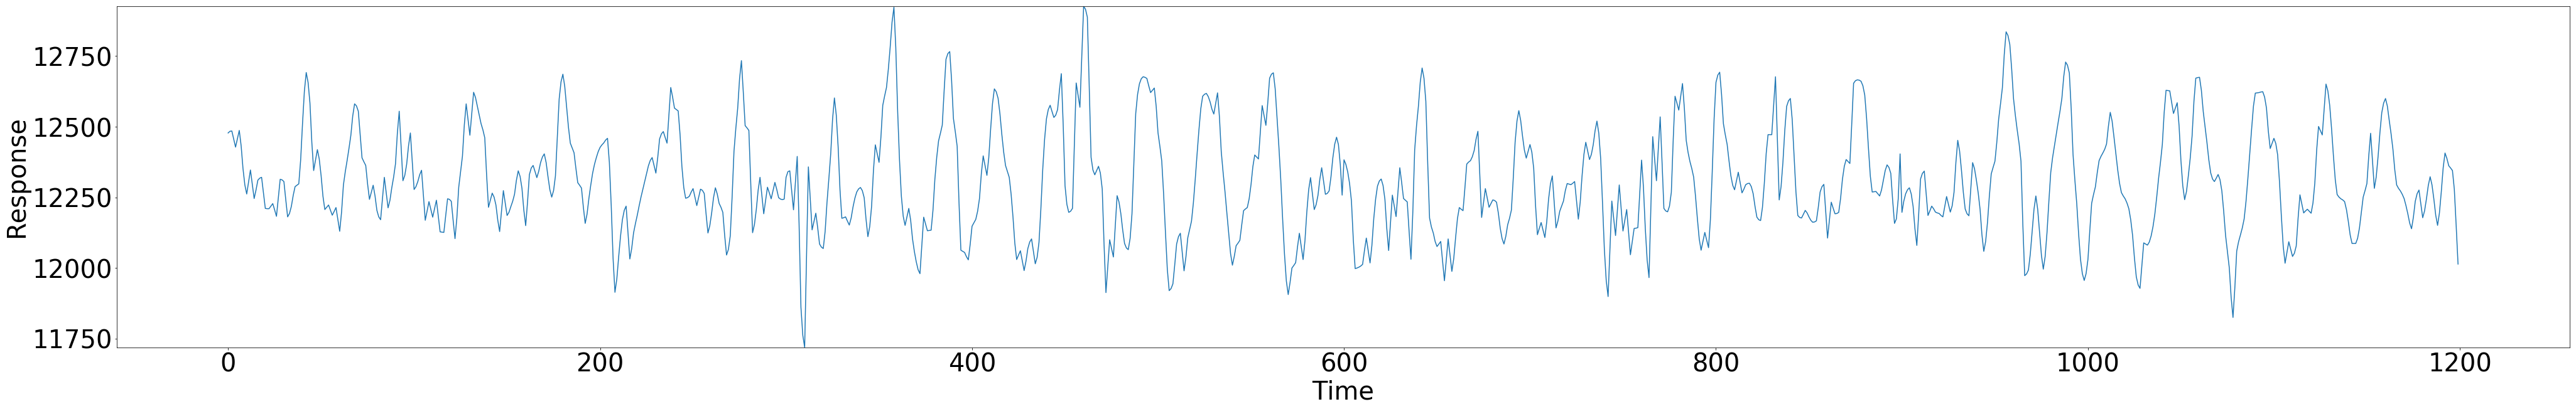

In [81]:
figsizex=70
figsizey=10
plotts(DATA.iloc[0])

The analyze prf demo doesn't tell us details of the physical size of the display.

However, we know the retinal size of the display (10 deg). Thus there are around 10 pixels per degree of visual angle

Therefore, Ill just put in a bunch of information that will return the same pixels per degree.

In [82]:
viewdist_cm=80
screenwidth_cm=14

stimulus = VisualStimulus(kaybar, viewdist_cm, screenwidth_cm, scale_factor, tr_length, ctypes.c_int16)

We can verify this is correct.

In [83]:
stimulus.ppd

9.998710971064115

Now make sure that the model is generating predictions appropriately.

In [84]:
model = og.GaussianModel(stimulus, utils.double_gamma_hrf)

In [85]:
plotmodelpred(model,x, y, sigma, hrf_delay, beta, baseline,figsizex,figsizey)

It makes sense to make the search grids smaller, since this stimulus is an order of magnitude smaller than the previous example

In [86]:
# X location grid
x_grid = (-7,7)

# Y location grid
y_grid = (-7,7)

# SD location grid. Here the minimum is set to 1 pixel. 
s_grid = (1/stimulus.ppd + 0.25,9)

# This would seem to have to be the beta parameter?
b_grid = (0.1,1.0)

# This would seem to baseline parameter?
h_grid = (-1.0,1.0)


x_bound = (-7,7)

y_bound = (-7.0,7)

s_bound = (1/stimulus.ppd, 12.0)

b_bound = (1e-8,None)

u_bound = (None,None)

h_bound = (-3.0,3.0)

## package the grids and bounds
grids = (x_grid, y_grid, s_grid, h_grid)

bounds = (x_bound, y_bound, s_bound, h_bound, b_bound, u_bound,)

In [87]:
Ns=5

In [88]:
fit = og.GaussianFit(model, DATA.iloc[0], grids, bounds, Ns=Ns, voxel_index=(1,2,3), auto_fit=True,verbose=2)

(array([-7.        , -7.        ,  0.35001289, -1.        ]), 41570076.51704028)
(array([-7.        , -7.        ,  0.35001289, -1.        ]), 41570076.51704028)
(array([-7.        , -7.        ,  0.35001289, -0.5       ]), 41489014.93972278)
(array([-7.        , -7.        ,  0.35001289,  0.        ]), 41415593.67302505)
(array([-7.        , -7.        ,  0.35001289,  0.5       ]), 41358434.52635493)
(array([-7.        , -7.        ,  0.35001289,  1.        ]), 41323912.365130484)
(array([-7.        , -7.        ,  2.51250967, -1.        ]), 41799466.654792935)
(array([-7.        , -7.        ,  2.51250967, -0.5       ]), 41798545.06660601)
(array([-7.        , -7.        ,  2.51250967,  0.        ]), 41793770.24727524)
(array([-7.        , -7.        ,  2.51250967,  0.5       ]), 41786603.345821306)
(array([-7.        , -7.        ,  2.51250967,  1.        ]), 41778767.19032051)
(array([-7.        , -7.        ,  4.67500645, -1.        ]), 41030798.897822514)
(array([-7.        , -7.

(array([-7.        ,  7.        ,  4.67500645, -1.        ]), 41643993.89885984)
(array([-7.        ,  7.        ,  4.67500645, -0.5       ]), 41629661.96463447)
(array([-7.        ,  7.        ,  4.67500645,  0.        ]), 41621238.912962556)
(array([-7.        ,  7.        ,  4.67500645,  0.5       ]), 41618126.319179565)
(array([-7.        ,  7.        ,  4.67500645,  1.        ]), 41619460.13317326)
(array([-7.        ,  7.        ,  6.83750322, -1.        ]), 40118990.83573444)
(array([-7.        ,  7.        ,  6.83750322, -0.5       ]), 39958116.85824285)
(array([-7.        ,  7.        ,  6.83750322,  0.        ]), 39848615.09887427)
(array([-7.        ,  7.        ,  6.83750322,  0.5       ]), 39788983.04425557)
(array([-7.        ,  7.        ,  6.83750322,  1.        ]), 39775888.60329574)
(array([-7.,  7.,  9., -1.]), 38648549.33105789)
(array([-7. ,  7. ,  9. , -0.5]), 38343087.60768)
(array([-7.,  7.,  9.,  0.]), 38130396.74520774)
(array([-7. ,  7. ,  9. ,  0.5]), 380090

(array([-3.5       ,  7.        ,  0.35001289,  0.        ]), 41467413.49201384)
(array([-3.5       ,  7.        ,  0.35001289,  0.5       ]), 41470734.89778973)
(array([-3.5       ,  7.        ,  0.35001289,  1.        ]), 41485213.24289184)
(array([-3.5       ,  7.        ,  2.51250967, -1.        ]), 41793529.43965812)
(array([-3.5       ,  7.        ,  2.51250967, -0.5       ]), 41794006.12453231)
(array([-3.5       ,  7.        ,  2.51250967,  0.        ]), 41794603.082295075)
(array([-3.5       ,  7.        ,  2.51250967,  0.5       ]), 41795418.44542357)
(array([-3.5       ,  7.        ,  2.51250967,  1.        ]), 41796472.09608337)
(array([-3.5       ,  7.        ,  4.67500645, -1.        ]), 40787473.62223504)
(array([-3.5       ,  7.        ,  4.67500645, -0.5       ]), 40675013.73859276)
(array([-3.5       ,  7.        ,  4.67500645,  0.        ]), 40593961.59315073)
(array([-3.5       ,  7.        ,  4.67500645,  0.5       ]), 40543626.37025067)
(array([-3.5       ,  7.   

(array([0. , 3.5, 9. , 1. ]), 34592980.7390037)
(array([ 0.        ,  7.        ,  0.35001289, -1.        ]), 41799411.50795315)
(array([ 0.        ,  7.        ,  0.35001289, -0.5       ]), 41798943.33184655)
(array([0.        , 7.        , 0.35001289, 0.        ]), 41798563.79595359)
(array([0.        , 7.        , 0.35001289, 0.5       ]), 41798651.20230451)
(array([0.        , 7.        , 0.35001289, 1.        ]), 41799242.01291388)
(array([ 0.        ,  7.        ,  2.51250967, -1.        ]), 41266845.32894108)
(array([ 0.        ,  7.        ,  2.51250967, -0.5       ]), 41191857.9006028)
(array([0.        , 7.        , 2.51250967, 0.        ]), 41129013.94643874)
(array([0.        , 7.        , 2.51250967, 0.5       ]), 41076863.341910064)
(array([0.        , 7.        , 2.51250967, 1.        ]), 41033788.498067856)
(array([ 0.        ,  7.        ,  4.67500645, -1.        ]), 38709188.80660514)
(array([ 0.        ,  7.        ,  4.67500645, -0.5       ]), 38352216.82169671)
(ar

(array([ 3.5,  3.5,  9. , -1. ]), 34613601.232197836)
(array([ 3.5,  3.5,  9. , -0.5]), 33865248.36853785)
(array([3.5, 3.5, 9. , 0. ]), 33322777.449559502)
(array([3.5, 3.5, 9. , 0.5]), 32988229.14512067)
(array([3.5, 3.5, 9. , 1. ]), 32856485.1137461)
(array([ 3.5       ,  7.        ,  0.35001289, -1.        ]), 40938599.62303697)
(array([ 3.5       ,  7.        ,  0.35001289, -0.5       ]), 40779085.116093025)
(array([3.5       , 7.        , 0.35001289, 0.        ]), 40639262.4988766)
(array([3.5       , 7.        , 0.35001289, 0.5       ]), 40519715.162702456)
(array([3.5       , 7.        , 0.35001289, 1.        ]), 40419077.96620159)
(array([ 3.5       ,  7.        ,  2.51250967, -1.        ]), 38836827.511378646)
(array([ 3.5       ,  7.        ,  2.51250967, -0.5       ]), 38453003.13463438)
(array([3.5       , 7.        , 2.51250967, 0.        ]), 38148530.976445794)
(array([3.5       , 7.        , 2.51250967, 0.5       ]), 37923952.15023653)
(array([3.5       , 7.        , 2.

(array([ 7.        ,  3.5       ,  6.83750322, -0.5       ]), 30656654.745642327)
(array([7.        , 3.5       , 6.83750322, 0.        ]), 29838009.494177967)
(array([7.        , 3.5       , 6.83750322, 0.5       ]), 29315913.53279379)
(array([7.        , 3.5       , 6.83750322, 1.        ]), 29086885.670883484)
(array([ 7. ,  3.5,  9. , -1. ]), 33272982.766783662)
(array([ 7. ,  3.5,  9. , -0.5]), 32364240.129577667)
(array([7. , 3.5, 9. , 0. ]), 31699394.904722724)
(array([7. , 3.5, 9. , 0.5]), 31282526.32715606)
(array([7. , 3.5, 9. , 1. ]), 31109014.00940656)
(array([ 7.        ,  7.        ,  0.35001289, -1.        ]), 38938222.73927696)
(array([ 7.        ,  7.        ,  0.35001289, -0.5       ]), 38533318.52197204)
(array([7.        , 7.        , 0.35001289, 0.        ]), 38195581.98158444)
(array([7.        , 7.        , 0.35001289, 0.5       ]), 37927638.345753245)
(array([7.        , 7.        , 0.35001289, 1.        ]), 37729219.456112385)
(array([ 7.        ,  7.        , 

(array([    3.89685702,    -0.43517998,     2.14085059,     1.35231786,
           0.87486059, 12305.2675    ]), 18601525.087338116)
(array([    3.89685702,    -0.43517998,     2.14085059,     1.35231786,
           0.25682661, 12305.2675    ]), 29485728.570189424)
(array([    3.89685702,    -0.43517998,     2.14085059,     1.35231786,
           1.25682659, 12305.2675    ]), 25119251.878471907)
(array([    3.89685702,    -0.43517998,     2.14085059,     1.35231786,
           0.81979014, 12305.2675    ]), 18496365.430955753)
(array([    3.89685702,    -0.43517998,     2.14085059,     1.35231786,
           0.81923944, 12305.2675    ]), 18496375.946921777)
(array([    3.89685702,    -0.43517998,     2.14085059,     1.35231786,
           0.82034085, 12305.2675    ]), 18496375.946921773)
(array([    3.89685702,    -0.43517998,     2.14085059,     1.35231786,
           0.81979014, 12305.2675    ]), 18496365.430955753)
(array([    3.89685702,    -0.43517998,     2.14085059,     1.3523178

(array([    3.34799723,    -0.38705297,     1.52281661,     1.35231786,
           0.81979014, 12305.26749912]), 17719019.95990389)
(array([    3.34799723,    -0.38705297,     1.1408506 ,     1.35231786,
           0.81979014, 12305.26749912]), 18703988.93919012)
(array([    3.34799723,    -0.38705297,     1.70205677,     1.35231786,
           0.81979014, 12305.26749912]), 17622117.00282509)
(array([    3.34799723,    -0.38705297,     1.69454709,     1.35231786,
           0.81979014, 12305.26749912]), 17621493.989797648)
(array([    3.34799723,    -0.38705297,     1.68687863,     1.35231786,
           0.81979014, 12305.26749912]), 17621270.6837821)
(array([    3.34799723,    -0.38705297,     1.68233891,     1.35231786,
           0.81979014, 12305.26749912]), 17621335.767340824)
(array([    3.34799723,    -0.38705297,     1.68687863,     1.35231786,
           0.81979014, 12305.26749912]), 17621270.6837821)
(array([    3.34799723,    -0.38705297,     1.68687863,     2.35231786,
    

(array([    0.65583195,    -0.29286729,     0.79844503,     1.21302908,
           0.73559001, 12305.26749913]), 27006305.07182343)
(array([    2.27386595,    -0.29286729,     0.79844503,     1.21302908,
           0.73559001, 12305.26749913]), 15345269.28579897)
(array([    1.65583198,    -0.29286729,     0.79844503,     1.21302908,
           0.73559001, 12305.26749913]), 16448930.558148395)
(array([    2.65583195,    -0.29286729,     0.79844503,     1.21302908,
           0.73559001, 12305.26749913]), 16053450.860982966)
(array([    2.21015901,    -0.29286729,     0.79844503,     1.21302908,
           0.73559001, 12305.26749913]), 15317610.368761547)
(array([    2.17387571,    -0.29286729,     0.79844503,     1.21302908,
           0.73559001, 12305.26749913]), 15314790.863417)
(array([    2.18111816,    -0.29286729,     0.79844503,     1.21302908,
           0.73559001, 12305.26749913]), 15314588.131362453)
(array([    2.18204564,    -0.29286729,     0.79844503,     1.21302908,
  

(array([    2.23016235,    -0.20713681,     0.83901038,     1.30401159,
           0.73678517, 12305.26749889]), 15254505.174515463)
(array([    2.2281537 ,    -0.20696068,     0.83734899,     1.30383921,
           0.73668096, 12305.26749889]), 15254486.855199527)
(array([    2.22862406,    -0.20700192,     0.83773803,     1.30387957,
           0.73670536, 12305.26749889]), 15254486.96382802)
(array([    2.22768335,    -0.20691944,     0.83695995,     1.30379884,
           0.73665656, 12305.26749889]), 15254489.30716499)
(array([    2.2281537 ,    -0.20696068,     0.83734899,     1.30383921,
           0.73668096, 12305.26749889]), 15254486.855199527)
(array([    3.2281537 ,    -0.20696068,     0.83734899,     1.30383921,
           0.73668096, 12305.26749889]), 18271459.790183682)
(array([    0.6101197 ,    -0.20696068,     0.83734899,     1.30383921,
           0.73668096, 12305.26749889]), 27543416.698092975)
(array([    2.2281537 ,    -0.20696068,     0.83734899,     1.30383921,

(array([    2.25434395,    -0.21564093,     0.89637006,     1.29250204,
           0.74598282, 12305.26750014]), 15249832.287396654)
(array([    2.21244206,    -0.21196674,     0.86171225,     1.28890593,
           0.74380897, 12305.26750014]), 15239977.14795221)
(array([    2.21273662,    -0.21199257,     0.86195588,     1.28893121,
           0.74382425, 12305.26750014]), 15239976.78842489)
(array([    2.21303412,    -0.21201866,     0.86220195,     1.28895674,
           0.74383969, 12305.26750014]), 15239977.453394666)
(array([    2.19731953,    -0.21702446,     0.88656278,     1.27402321,
           0.75096754, 12305.2675014 ]), 15231764.876990829)
(array([    2.21273662,    -0.21199257,     0.86195588,     1.28893121,
           0.74382425, 12305.26750014]), 15239976.78842489)
(array([    2.19731953,    -0.21702446,     0.88656278,     1.27402321,
           0.75096754, 12305.2675014 ]), 15231764.876990829)
(array([    2.17237417,    -0.22516623,     0.92637757,     1.24990156,


(array([    2.18412185,    -0.20740492,     0.90504795,     2.26219927,
           0.75653409, 12305.26749939]), 16545455.65411394)
(array([    2.18412185,    -0.20740492,     0.90504795,    -0.35583473,
           0.75653409, 12305.26749939]), 20439510.932110142)
(array([    2.18412185,    -0.20740492,     0.90504795,     1.26219927,
           0.75653409, 12305.26749939]), 15229003.771373725)
(array([    2.18412185,    -0.20740492,     0.90504795,     0.6441653 ,
           0.75653409, 12305.26749939]), 15921550.529696677)
(array([    2.18412185,    -0.20740492,     0.90504795,     1.64416527,
           0.75653409, 12305.26749939]), 15415717.530237678)
(array([    2.18412185,    -0.20740492,     0.90504795,     1.30131609,
           0.75653409, 12305.26749939]), 15228167.495299999)
(array([    2.18412185,    -0.20740492,     0.90504795,     1.28894087,
           0.75653409, 12305.26749939]), 15227919.610572685)
(array([    2.18412185,    -0.20740492,     0.90504795,     1.28866074

(array([    2.17845355,    -0.20799003,     0.9108651 ,     1.28435412,
           0.76012175, 12305.26749928]), 15227525.408010244)
(array([    2.17845355,    -0.20799003,     0.9108651 ,     1.28435412,
           0.76012175, 12305.26749927]), 15227525.408010246)
(array([    2.17845355,    -0.20799003,     0.9108651 ,     1.28435412,
           0.76012175, 12305.26749928]), 15227525.408010244)
(array([    2.17845355,    -0.20799003,     0.9108651 ,     2.28435412,
           0.76012175, 12305.26749928]), 16596372.67726199)
(array([    2.17845355,    -0.20799003,     0.9108651 ,    -0.33367988,
           0.76012175, 12305.26749928]), 20310046.88285491)
(array([    2.17845355,    -0.20799003,     0.9108651 ,     1.28435412,
           0.76012175, 12305.26749928]), 15227525.408010244)
(array([    2.17845355,    -0.20799003,     0.9108651 ,     0.66632015,
           0.76012175, 12305.26749928]), 15880102.060011953)
(array([    2.17845355,    -0.20799003,     0.9108651 ,     1.66632012,

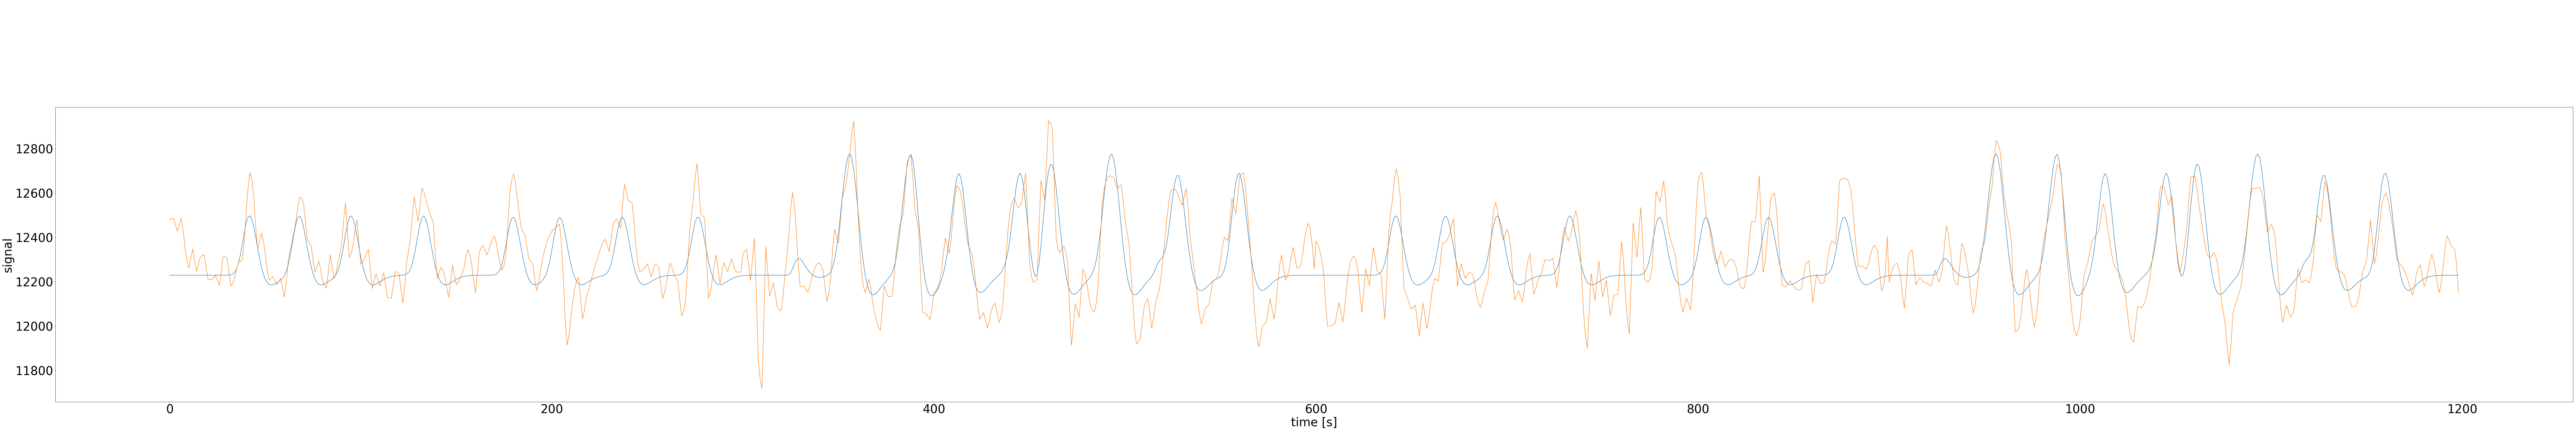

In [89]:
plotprfpred(fit,kaybar,30,[],[])

In [90]:
fit.rsquared

0.6357045794887284

This seems to have provided an okish fit

The figure is a bit useless like this though, lets just have a look at some smaller portions of data

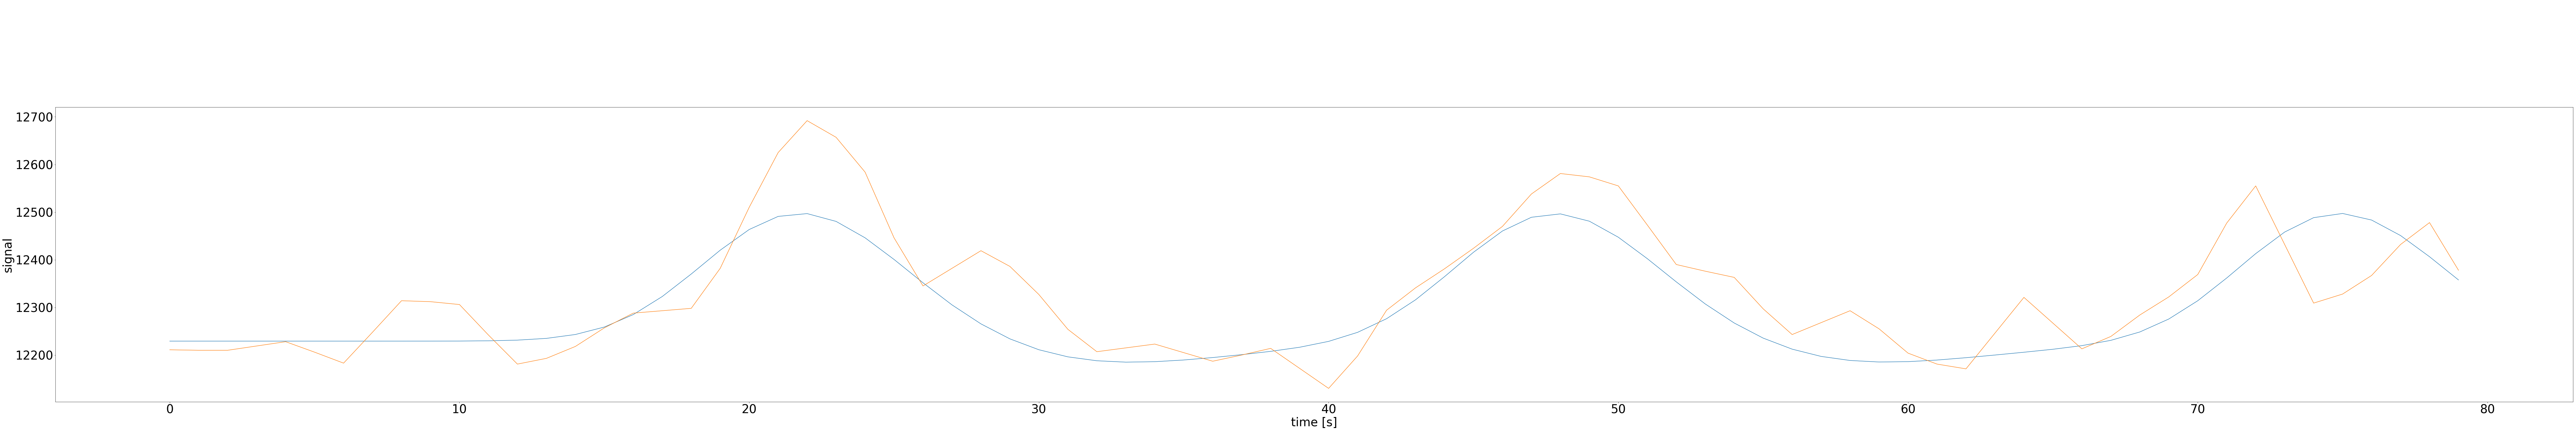

In [91]:
plotprfpred(fit,kaybar,30,20,100)

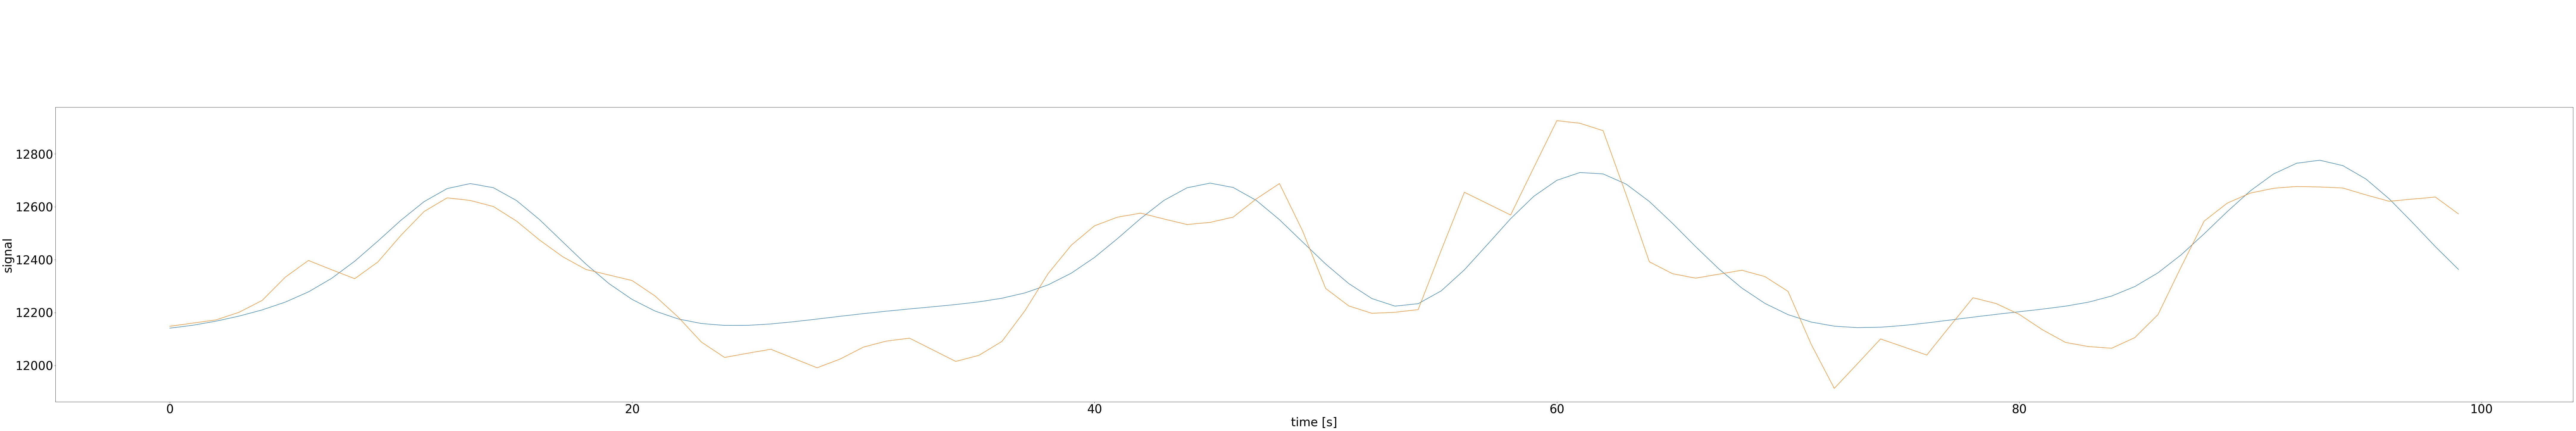

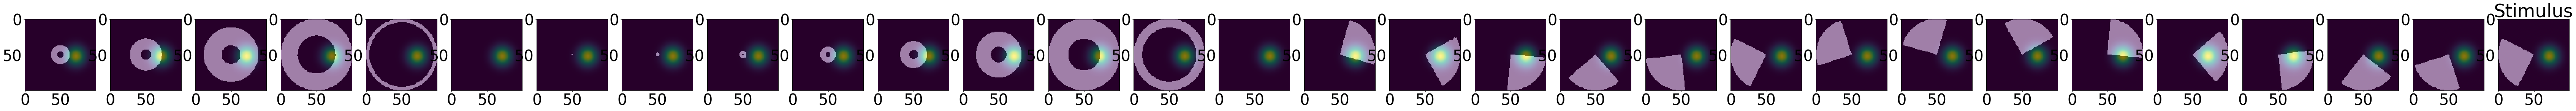

In [92]:
plotprfpred(fit,kaybar,30,400,500)


The model seems to capture many properties of the data quite well.

It would be nice if I could determine some way of plotting these prfs. 

In [96]:
fit.estimate

array([    2.17743359,    -0.20832293,     0.91249304,     1.2907844 ,
           0.76057241, 12305.26749936])

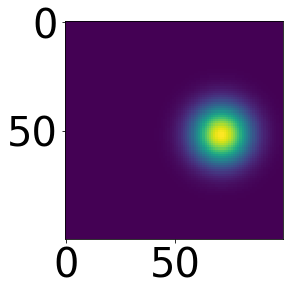

In [95]:
plt.imshow(fit.receptive_field)

Now do all 10 fits in a loop

In [97]:
fits=list()

for vox in range(10):
    fits.append(og.GaussianFit(model, DATA.iloc[vox], grids, bounds, Ns=Ns, voxel_index=(1,2,vox), auto_fit=True,verbose=1))

VOXEL=(001,002,000)   TIME=034   RSQ=0.64  EST=[    6.1878     2.1874     0.9125     1.2908     0.7606 12305.2675]
VOXEL=(001,002,001)   TIME=021   RSQ=0.53  EST=[   0.7006    5.1986    0.5736    0.3109    0.4773 7729.2414]
VOXEL=(001,002,002)   TIME=019   RSQ=0.12  EST=[    5.232      8.0642     2.1979    -0.9042     0.1321 11214.6592]
VOXEL=(001,002,003)   TIME=034   RSQ=0.67  EST=[   5.9663    1.2784    0.9153   -0.4112    0.5456 8076.1908]
VOXEL=(001,002,004)   TIME=022   RSQ=0.15  EST=[    0.0507     0.5369     1.1966     1.3661     0.2335 11782.4125]
VOXEL=(001,002,005)   TIME=029   RSQ=0.28  EST=[   6.2462    0.4795    0.9262   -0.13      0.1969 5904.7779]
VOXEL=(001,002,006)   TIME=035   RSQ=0.08  EST=[   5.5087    0.3258    0.1       0.4745    0.1951 6177.987 ]
VOXEL=(001,002,007)   TIME=044   RSQ=0.28  EST=[   0.2338    2.0759    2.383     0.1548    0.642  8357.683 ]
VOXEL=(001,002,008)   TIME=043   RSQ=0.22  EST=[    1.3415     0.0948     0.1        0.2764     0.3674 14113.0

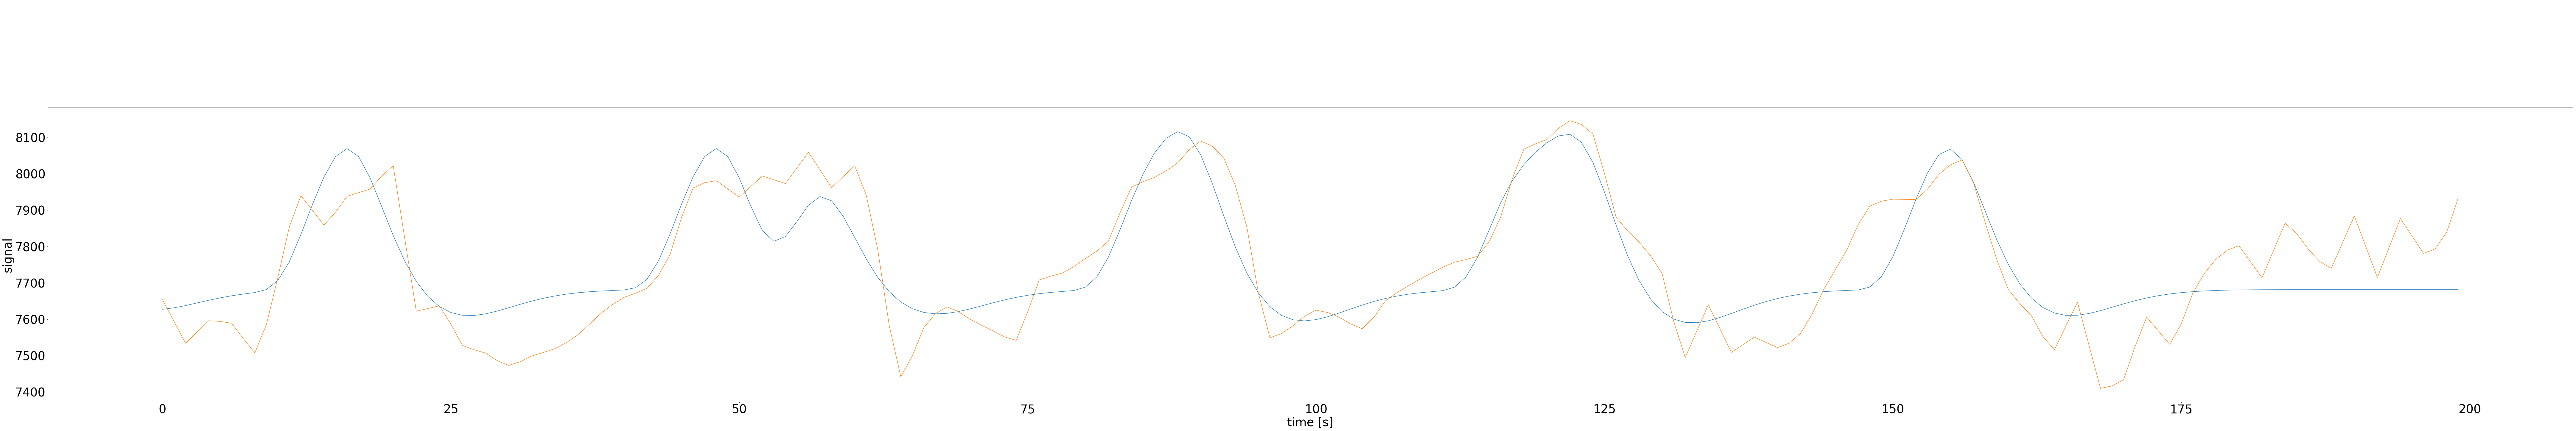

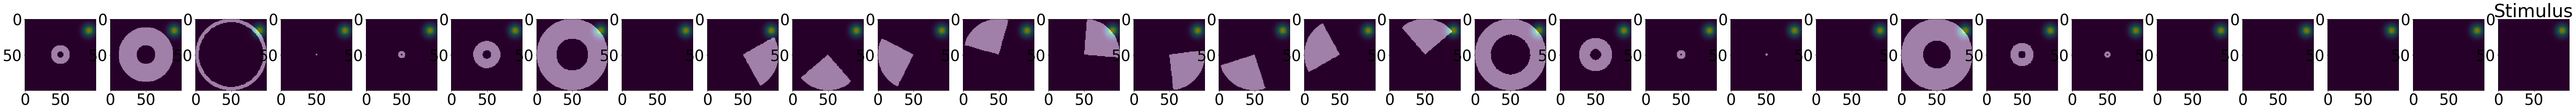

In [98]:
plotprfpred(fits[1],kaybar,30,400,600)

I'm now going to return a summary of these fits into a dataframe. Note that the idx column is essentially arbitrary at the moment.

However, this would be useful for relating the fits to the actual voxel coordinates of nifti volumes. 

In [113]:
import popeye.plotting as peplt
x=list()
y=list()
s=list()
R2=list()
idx=list()

for results in fits:
    x.append(results.estimate[0])
    y.append(results.estimate[1])
    s.append(results.estimate[2])
    R2.append(results.rsquared)
    idx.append(results.voxel_index)
    

import pandas as pd    
PRF_FRAME=pd.DataFrame()
PRF_FRAME['X'] = x 
PRF_FRAME['Y'] = y 
PRF_FRAME['SD'] = s
PRF_FRAME['R2'] = R2
PRF_FRAME['idx'] = idx

In [114]:
PRF_FRAME

X         Y        SD        R2        idx
0  2.177434 -0.208323  0.912493  0.635705  (1, 2, 0)
1  3.974223  3.351330  0.573629  0.528660  (1, 2, 1)
2  4.003946 -7.000000  2.197914  0.119992  (1, 2, 2)
3  1.214736 -0.398371  0.915264  0.669338  (1, 2, 3)
4  0.536172  0.027200  1.196611  0.150692  (1, 2, 4)
5  0.479157 -0.017749  0.926151  0.281543  (1, 2, 5)
6  0.232845 -0.227828  0.100013  0.082196  (1, 2, 6)
7  2.019468  0.480930  2.382955  0.276703  (1, 2, 7)
8  0.021553  0.092339  0.100013  0.215244  (1, 2, 8)
9  0.009279  0.009972  0.100013  0.084320  (1, 2, 9)

We can use the 'field_coverage' function to provide a plot of the prf fits

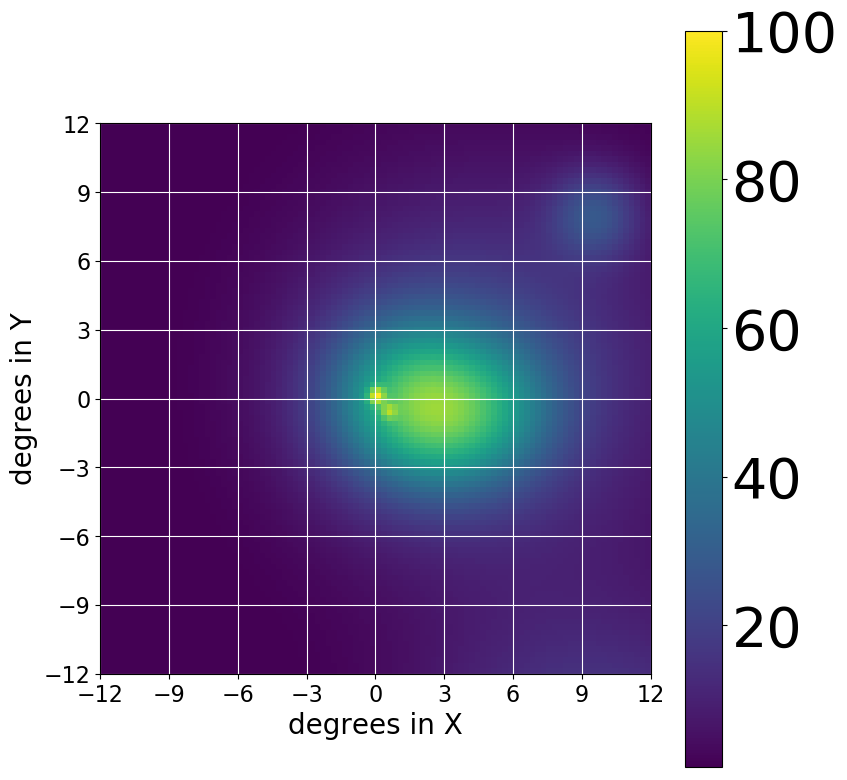

In [193]:
z=peplt.field_coverage(PRF_FRAME['X'],PRF_FRAME['Y'],PRF_FRAME['SD'],stimulus.deg_x,stimulus.deg_y)

This doesn't really seem to correspond well to the data in the table...

In [194]:
peplt.location_and_size_map(PRF_FRAME['X'],PRF_FRAME['Y'],PRF_FRAME['SD'],'b')

This plot seems to better represent the data in the table. I'm going to try and create the field coverage plot myself.

Generate the receptive fields and sum them. Note that these will be in pixel coordinates 

In [195]:
from popeye.spinach import generate_og_receptive_field

field = np.zeros_like(fits[1].receptive_field)

for results in fits:
    rf = generate_og_receptive_field(results.estimate[0],results.estimate[1],results.estimate[2],stimulus.deg_x,stimulus.deg_y)
    field += rf

Normalise the plot and change the axis to degrees from the fixation

In [196]:
field /= np.max(field)
field *= 100

plt.imshow(field,extent=(-5,5,-5,5))
plt.xticks(np.arange(-5,5,1),fontsize='12')
plt.yticks(np.arange(-5,5,1),fontsize='12')
plt.grid('on',c='w')
plt.colorbar()

This is better. It seems as though the original function assumed a different display for some reason. I'd like to create some more elegant plots in ggplot, however. 